In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint as pp
import networkx as nx

!qbraid jobs enable amazon_braket

You have already enabled qBraid Quantum Jobs in the amazon_braket environment.


In [3]:
from braket.ahs.atom_arrangement import AtomArrangement
from quera_ahs_utils.plotting import show_register

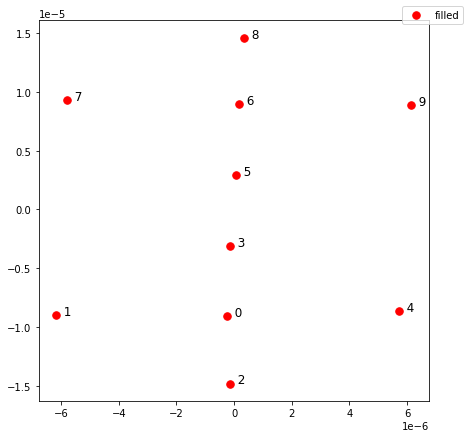

In [4]:
points = [
(-0.04100006,-1.4860001),
(-1.011,-1.4760001),
(-0.021000061,-2.426),
(-0.021000061,-0.50600004),
(0.93899995,-1.416),
(0.008999939,0.47399995),
(0.02899994,1.464),
(-0.95100003,1.5239999),
(0.05899994,2.394),
(1.009,1.454),
]

a = 6.1e-6  # meters
N_atoms = len(points)

register = AtomArrangement()
for x,y in points:
    register.add([x*a, y*a])


fig = show_register(register)
plt.show()

In [5]:
from braket.ahs.hamiltonian import Hamiltonian

H = Hamiltonian()

In [6]:
def gaussian(t,T, A, sigma):
    return A*np.exp(-(t-T/2)**2/(2*sigma**2))

def exp(t, T, A):
    return A*np.exp(t/T)

def sinc(t):
    return np.sin(t)/t

def sinc_squared(t, a, w):
    return a*sinc(w*t/2 -np.pi)**2

def logistic(t,a,b,c):
    return a/(1+b*np.e**(-c*x))
    

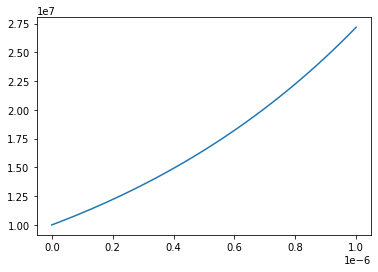

In [7]:
tlist = np.linspace(0, 1e-6, 40)
plt.plot(tlist, [exp(t, 1e-6, 1e7) for t in tlist])

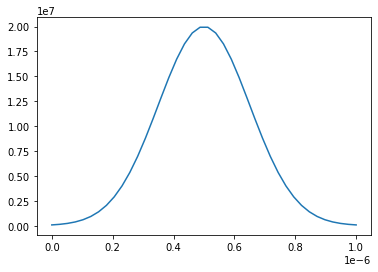

In [8]:
tlist = np.linspace(0, 1e-6, 40)
plt.plot(tlist, [gaussian(t, 1e-6, 2e7, 1.5e-7) for t in tlist])

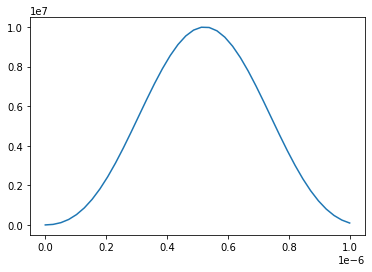

In [9]:
tlist = np.linspace(0, 1e-6, 40)
plt.plot(tlist, [sinc_squared(t, 1e7, 1.2e7) for t in tlist])

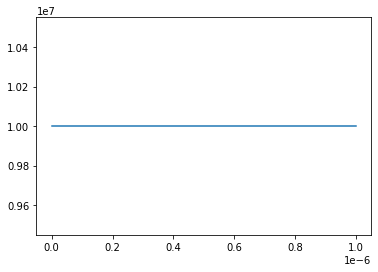

In [10]:
tlist = np.linspace(0, 1e-6, 40)
plt.plot(tlist, [logistic(t, 1e7, 0.5, 1.6e6) for t in tlist])

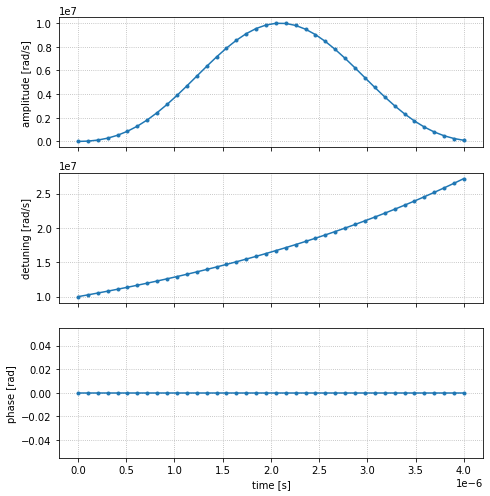

<Figure size 432x288 with 0 Axes>

In [16]:
from quera_ahs_utils.plotting import show_global_drive 
from quera_ahs_utils.drive import get_drive

omega_min = 0       
omega_max = 2.5e6 * 2 * np.pi
detuning_min = -9e6 * 2 * np.pi
detuning_max = 7e6 * 2 * np.pi

time_max = 4e-6
time_ramp = 0.15*time_max

time_points = np.linspace(0, time_max, 40)
omega_values = [sinc_squared(t, 1e7, 1.2e7) for t in tlist]
#omega_values = [gaussian(t, 1e-6, 2e7, 1.5e-7) for t in tlist]
detuning_values = [exp(t, 1e-6, 1e7) for t in tlist]
phase_values = [0 for t in tlist]

drive = get_drive(time_points, omega_values, detuning_values, phase_values)
H += drive

show_global_drive(drive)
plt.savefig("sinc_drive.png")
plt.show()

In [12]:
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=H
)

In [13]:
from braket.devices import LocalSimulator

classical_device = LocalSimulator("braket_ahs")

nshots = 1
task = classical_device.run(ahs_program, shots=nshots)

# The result can be downloaded directly into an object in the python session:
result = task.result()

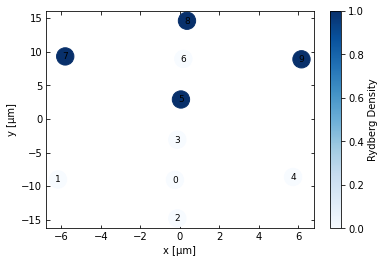

In [14]:
from quera_ahs_utils.analysis import get_avg_density
from quera_ahs_utils.plotting import plot_avg_density

n_rydberg = get_avg_density(result)
fig,ax = plot_avg_density(n_rydberg, register,cmap=plt.cm.Blues)
plt.savefig("sinc_drive_rydberg_states")
plt.show()

In [1]:
def points_to_unit_graph(scale=1, atom_list=[]):
    edge_dict = {}
    for i in range(len(atom_list)):
        for j in range(len(atom_list)):
            if(j == i):
                continue
            if np.sqrt((atom_list[i][0]-atom_list[j][0])**2 + (atom_list[i][1]-atom_list[j][1])**2) <= scale:
                if(i in edge_dict):
                    edge_dict[i].append(j)
                else:
                    edge_dict[i] = [j]
    print(edge_dict)
    return nx.from_dict_of_lists(edge_dict)
def scale_units(atom_pos, scale=4.0*1e-6):
    out = []
    for a in atom_pos:
        out.append(a[0] * scale, a[1] * scale)

In [72]:
# atoms, graph = generate_unit_disk(atoms_l, atoms_w)
print(points)
atom_pos = [(0,0),(0,1),(0,-1),(1,0), (-1,0)]
atoms = AtomArrangement()
for atom in points:
    atoms.add(atom)
graph = points_to_unit_graph(scale=1, atom_list=points)

[(-0.04100006, -1.4860001), (-1.011, -1.4760001), (-0.021000061, -2.426), (-0.021000061, -0.50600004), (0.93899995, -1.416), (0.008999939, 0.47399995), (0.02899994, 1.464), (-0.95100003, 1.5239999), (0.05899994, 2.394), (1.009, 1.454)]
{0: [1, 2, 3, 4], 1: [0], 2: [0], 3: [0, 5], 4: [0], 5: [3, 6], 6: [5, 7, 8, 9], 7: [6], 8: [6], 9: [6]}


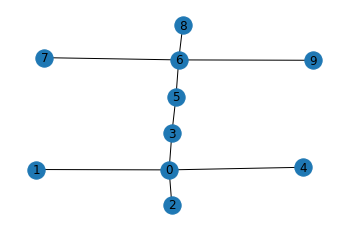

In [73]:
fig, ax = plt.subplots()
pos = {ii: points[ii] for ii in graph.nodes()}
nx.draw(graph, pos=pos, ax=ax, with_labels=True)
plt.savefig("con_graph_with_one_node_turned_off.png")
plt.show()